In [27]:
### - import all the usual stuff - ###

import sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')

import gw150814_simulator as gs
from gw150814_simulator import GW150814, defaults, GW150814_Additive
# import module

import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import scipy
from scipy.signal import welch
import scipy.stats
import pytorch_lightning as pl
from collections import defaultdict
from tqdm import tqdm
import jax.numpy as jnp
import plotfancy as pf
pf.housestyle_rcparams()

from ipywidgets import interactive_output, VBox, HBox, FloatSlider, Checkbox, FloatLogSlider, FloatRangeSlider, FloatText
import sounddevice as sd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os, sys

from simulators.additive import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

### Procedure
1) Generate stochastic signal - this can simulate a PSD or a whitened PSD - doesn't matter (the generator runs on it)
2) Feed signal into comb. Comb generates teeth of 

In [2]:

# def comb(x, x0=1, dx=1, f0=49, df=1, nf=6):
#     global grid
#     grid = np.arange(len(x))*dx+x0
#     global i0
#     i0 = int(np.ceil((f0 - x0) / dx))
#     global indices
#     indices = np.arange(nf)+i0
#     global f_comb
#     f_comb = np.copy(x)
#     teeth_freqs_raw = f_comb[f_comb==indices]
#     teeth_freqs = np.random.normal(loc=10**3*teeth_freqs_raw, scale=1, size=nf)
#     f_comb[f_comb==indices] = teeth_freqs
#     return f_comb
    


In [3]:
def gen_grid(x0,dx,nx):
    return np.arange(nx)*dx+x0

def gen_white_psd(nf=6000):
    white_noise = np.random.normal(loc=0, scale=1, size=nf)
    white_noise_psd = welch(white_noise, fs=0.25, window='tukey', nperseg=1000)
    return white_noise_psd


In [4]:
f = gen_white_psd()[1]

In [5]:
def comb(
    psd,
    df=1,
    f0=1,
    spacing=10,
    nharmonics=6,
    mean_amp=10**3,
    jitter='lognormal',
    jitter_strength=0.5,
    x0=0.0
):
    psd_out = np.copy(psd)
    clean_comb = np.ones(len(psd))
    
    nbins = len(psd)
    freqs = f0 + spacing * np.arange(nharmonics)
    indices = np.round((freqs - x0) / df).astype(int)

    teeth = (indices >= 0) & (indices < nbins)
    indices = indices[teeth]

    if jitter == 'lognormal':
        amps = np.random.lognormal(mean=np.log(mean_amp), sigma=jitter_strength, size=len(indices))
    elif jitter == 'exponential':
        amps = np.random.exponential(scale=mean_amp, size=len(indices))
    elif jitter == 'none':
        amps = np.full(len(indices), mean_amp)
    else:
        raise ValueError(f"Unsupported jitter type: {jitter}")

    np.add.at(psd_out, indices, amps)
    np.add.at(clean_comb, indices, amps)

    return psd_out, clean_comb

True

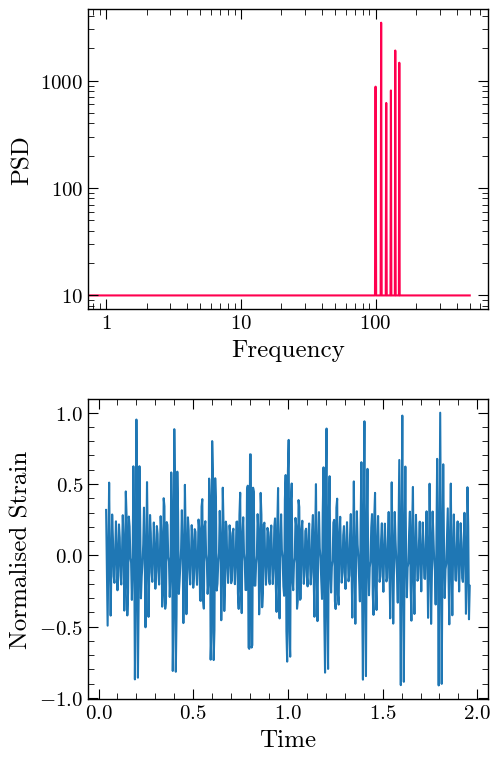

In [30]:
### PLOT EXAMPLE COMB FOUND W/IN WHITE NOISE ####
out,comb_mask = comb(f, f0=100)

fig, ax = pf.create_plot(size=(4,3))
# ax.loglog(out, label='noise+comb', color='#ff004f')
ax.loglog(comb_mask+9, label='comb', color='#ff004f')
# ax.legend()
ax.set_xlabel('Frequency')
ax.set_ylabel('PSD')

td_sig = np.fft.irfft(out)
td_clean = np.fft.fft(out)

ax2 = fig.add_axes((0,-1.3,1,1))

chop=10
ax2.plot(np.linspace(0,2,len(td_clean))[chop:-chop],td_clean[chop:-chop]/np.max(td_clean[chop:-chop]))
ax2.set_xlabel('Time')
ax2.set_ylabel('Normalised Strain')
# ax2.plot(np.linspace(0,2,len(td_sig)),td_sig)
pf.fix_plot([ax,ax2])

In [ ]:
def comb_plotter(f0, df, nf):
    _, sim_comb = comb()